In [26]:
import numpy as np 
import pandas as pd 
import os
import re
import statsmodels.api as sm

import itertools
import matplotlib.pyplot as plt
import matplotlib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import glob
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)

In [27]:
def custom_sort(item):
    if item.endswith('basal'):
        return 0  
    else:
        return int(item.split('uM')[0].split('_')[-1])
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [28]:
## read in data, div19_26uMbicucilin, 19_basal
lines_to_skip = 10 # adjust 

# count the number of header lines
EXPERIMENT_TIME = "1_MIN"
plate_type = 'DIV19' #adjust

PERTURBATION = "CNO" # adjust
firstTableHeading = "Number of Spikes"
## conditions taken: ### we will define this as dose1,dose2, dose3, dose4, each incrementing in terms of doses

FOLDER_PATH = f"{parent}/data/Div19_Bicucilin/" #
folder_dict = {}
balances= {"basal": "",
        "dose1": "",
        "dose2": "",
        "dose3": "",
        "dose4": ""
        }

## WALK Through folder of interest
for dirpath, dirnames, filenames in os.walk(FOLDER_PATH):
    if dirpath != FOLDER_PATH:
        folder_dict[dirpath.split("/")[-1]] = dirpath
    elif not dirnames:
        folder_dict['basal'] = dirpath

## get doses names in increasing order 
dose_names = [name for name in folder_dict.keys() if 'basal' not in name]
dose_names.sort(key=custom_sort)

# Initialize balances dictionaryd
balances = {"basal": "basal"}

## map sorted doses
for i, dose_name in enumerate(dose_names, start=1):
    balances[f"dose{i}"] = dose_name.split("_")[-1]

print("Balances:", balances)


Balances: {'basal': 'basal', 'dose1': '2uMbicucilin', 'dose2': '6uMbicucilin', 'dose3': '26uMbicucilin'}


In [29]:
## now only select the control and maximum
last = list(balances.keys())[-1]
balances = {k: balances[k] for k in ('basal', f'{last}')}
getnums_f = lambda x: [int(num) for num in re.findall(r'\d+', x.split("_")[-1])]
concnums = list(map(getnums_f, list(folder_dict.keys())))
concnums = list(itertools.chain(*concnums))
folder_dict = {k: folder_dict[k] for k in folder_dict.keys() if any(x in k for x in ('basal', str(max(concnums))))}
folder_dict, balances

({'Div19_26uMbicucilin': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/Div19_Bicucilin/Div19_26uMbicucilin',
  'Div19_basal': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/Div19_Bicucilin/Div19_basal'},
 {'basal': 'basal', 'dose3': '26uMbicucilin'})

In [30]:
def read_csvs_to_dict(folder, lines_to_skip=10):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        cond = (file.split("/")[-2].split("_")[-1])
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            df['Subject'] = plate_key
            data_dict[plate_key] = df
    return data_dict
all_files_dict = {}

for dose, folder in folder_dict.items():
    all_files_dict[dose] = read_csvs_to_dict(folder)
for dose, files_dict in all_files_dict.items():
    print(files_dict.keys())

dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])


In [31]:
def concat_plates(plates_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in plates_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value for key, value in testparams_concat.items()}
    return testparams_concat
doses = {}
for dose, plates in all_files_dict.items():
    doses[dose] = concat_plates(plates, firstTableHeading)

doses.keys()

dict_keys(['Div19_26uMbicucilin', 'Div19_basal'])

In [32]:
def remove_mean_SEM(test_dict, chemical_type):
    for key, value in test_dict.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            test_dict[key] = value.drop(index=to_drop)
        test_dict[key]['Chemical_Type']=chemical_type
    return test_dict
for dose, parameter_dict in doses.items():
    doses[dose] = remove_mean_SEM(parameter_dict, dose)

doses.keys()

dict_keys(['Div19_26uMbicucilin', 'Div19_basal'])

In [33]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    plates = list(experiment_df['Subject'])
    chems = list(experiment_df['Chemical_Type'].apply(lambda x: x.split("_")[-1]))
    experiment_df.index = [f"Replicate{i+1}" for i in range(len(experiment_df))]
    experiment_df.drop(columns='Subject', inplace=True)
    return experiment_df
for dose, test_dict in doses.items():
    for test_name, df in test_dict.items():
        test_dict[test_name] = rename_row_names(df)
    doses[dose] = test_dict


In [34]:
## balanced defined as  
dmapped = {}
for bkey, bval in balances.items():
    for dkey, dval in doses.items():
        if bval == dkey.split("_")[-1]:
            dmapped[bkey] = dval

dmapped.keys(), type(list(dmapped.values())[0])

(dict_keys(['basal', 'dose3']), dict)

In [35]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type" and gene !="Subject":
                df[gene]= df[gene].astype(float)
    return all_concat

tests_mapped = combine_chem_types(dmapped)
tests_mapped['Network Burst Duration - Avg (sec)']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.579647,0.859407,0.230038,0.678855,0.830284,0.654184,0.481274,0.931357,Div19_basal
Replicate2,0.601540,0.249991,0.379989,0.698682,0.807410,0.231761,0.773275,0.632968,Div19_basal
Replicate3,0.218853,0.303412,1.297274,0.602706,0.251728,0.340530,0.650301,0.695178,Div19_basal
Replicate4,0.188526,0.496046,0.262803,0.709955,0.424274,0.354893,1.039538,0.654893,Div19_basal
Replicate5,0.228881,0.522489,0.430885,0.789491,0.286888,0.347982,0.803297,0.409023,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate32,0.455670,0.475602,0.554639,0.356517,1.047354,0.998121,0.501324,0.733050,Div19_26uMbicucilin
Replicate33,0.428454,0.769746,0.556568,0.533986,0.517722,0.618200,0.401650,0.578492,Div19_26uMbicucilin
Replicate34,0.522917,0.446758,0.599170,0.424805,0.387209,0.561704,0.502975,0.635415,Div19_26uMbicucilin
Replicate35,0.499745,0.522296,0.388505,0.525357,0.864262,0.862033,0.525369,0.578219,Div19_26uMbicucilin


In [36]:
def impute_nans(testparam, table):
    chem_types = table['Chemical_Type']
    table = table.drop(columns=['Chemical_Type'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)
    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['Chemical_Type'] = chem_types
    return imputed_df

# if nans in all columns, skip. need to remove chemtype and subject bc these will never have nans
testsI_mapped = {test_param: impute_nans(test_param, table) for test_param, table in tests_mapped.items() \
    if not table.loc[:, ~(table.columns.isin(['Chemical_Type']))].isna().all().all()
} 
testsI_mapped['Network Burst Duration - Avg (sec)']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.579647,0.859407,0.230038,0.678855,0.830284,0.654184,0.481274,0.931357,Div19_basal
Replicate2,0.601540,0.249991,0.379989,0.698682,0.807410,0.231761,0.773275,0.632968,Div19_basal
Replicate3,0.218853,0.303412,1.297274,0.602706,0.251728,0.340530,0.650301,0.695178,Div19_basal
Replicate4,0.188526,0.496046,0.262803,0.709955,0.424274,0.354893,1.039538,0.654893,Div19_basal
Replicate5,0.228881,0.522489,0.430885,0.789491,0.286888,0.347982,0.803297,0.409023,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate32,0.455670,0.475602,0.554639,0.356517,1.047354,0.998121,0.501324,0.733050,Div19_26uMbicucilin
Replicate33,0.428454,0.769746,0.556568,0.533986,0.517722,0.618200,0.401650,0.578492,Div19_26uMbicucilin
Replicate34,0.522917,0.446758,0.599170,0.424805,0.387209,0.561704,0.502975,0.635415,Div19_26uMbicucilin
Replicate35,0.499745,0.522296,0.388505,0.525357,0.864262,0.862033,0.525369,0.578219,Div19_26uMbicucilin


In [58]:
## only unt2!!!
unt2_tests = {key: val[['unt2', 'Chemical_Type']] for key, val in testsI_mapped.items()}

In [59]:
for x in unt2_tests:
    print(unt2_tests[x])

                 unt2        Chemical_Type
Replicate1   2.135017          Div19_basal
Replicate2   1.878548          Div19_basal
Replicate3   2.567195          Div19_basal
Replicate4   7.638564          Div19_basal
Replicate5   1.001461          Div19_basal
...               ...                  ...
Replicate32  7.671530  Div19_26uMbicucilin
Replicate33  7.600459  Div19_26uMbicucilin
Replicate34  9.812839  Div19_26uMbicucilin
Replicate35  4.013339  Div19_26uMbicucilin
Replicate36  6.732597  Div19_26uMbicucilin

[72 rows x 2 columns]
             unt2        Chemical_Type
Replicate1    8.0          Div19_basal
Replicate2    8.0          Div19_basal
Replicate3    8.0          Div19_basal
Replicate4    8.0          Div19_basal
Replicate5    8.0          Div19_basal
...           ...                  ...
Replicate32   8.0  Div19_26uMbicucilin
Replicate33   8.0  Div19_26uMbicucilin
Replicate34   7.0  Div19_26uMbicucilin
Replicate35   8.0  Div19_26uMbicucilin
Replicate36   8.0  Div19_26uMbic

In [47]:
colors = list(matplotlib.colors.cnames.keys())


In [48]:
os.path.abspath(FOLDER_PATH)

'/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/Div19_Bicucilin'

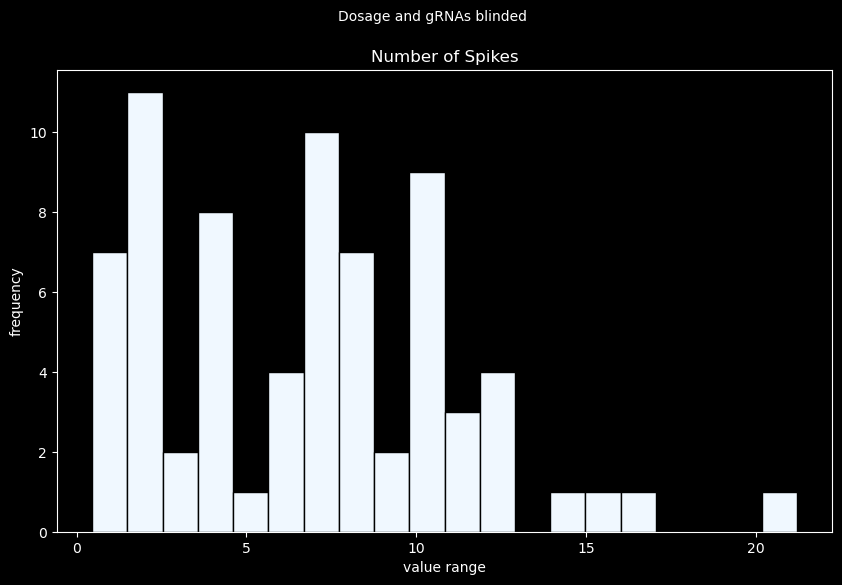

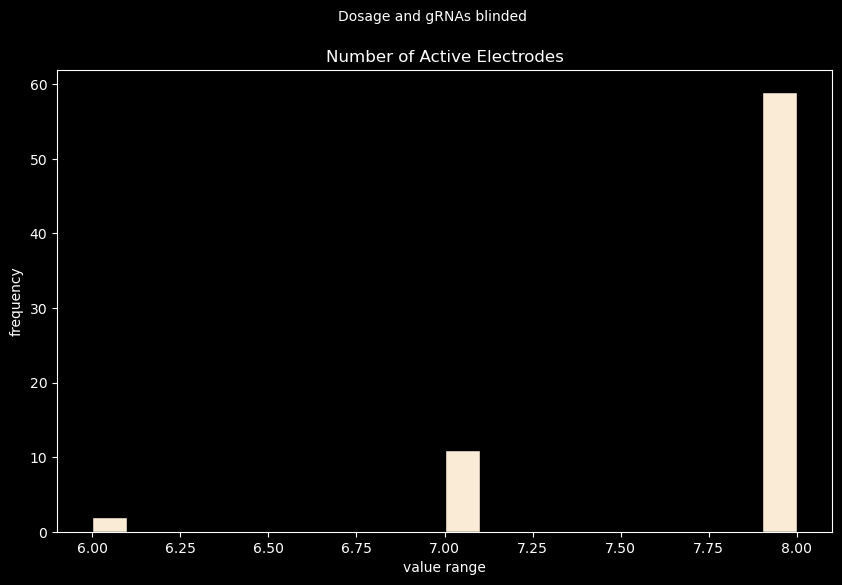

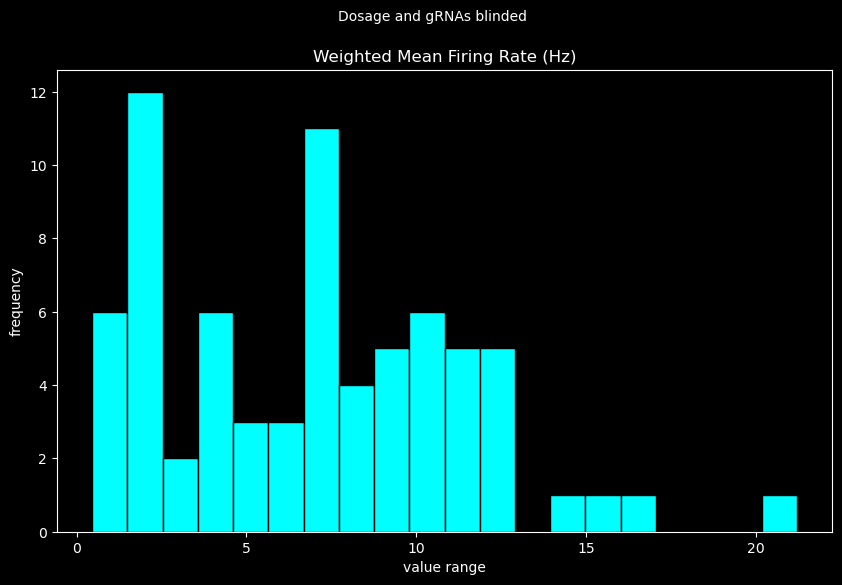

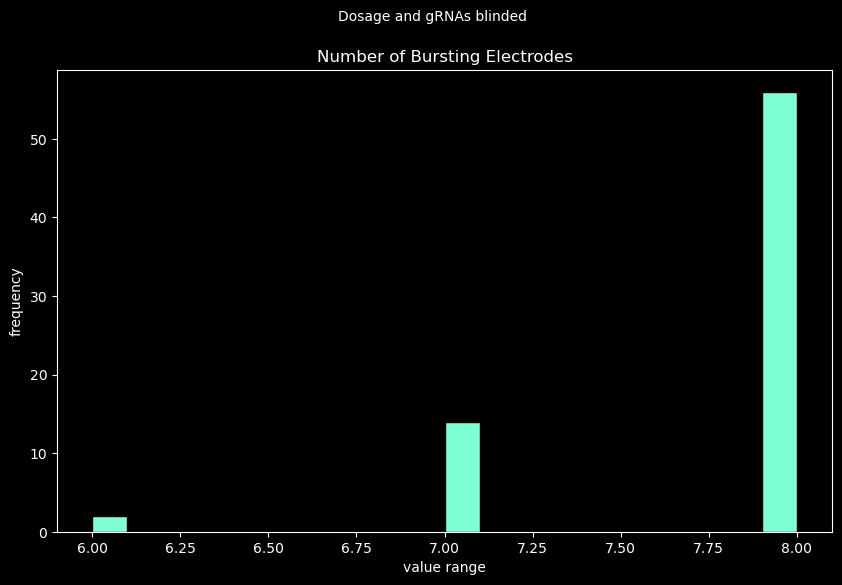

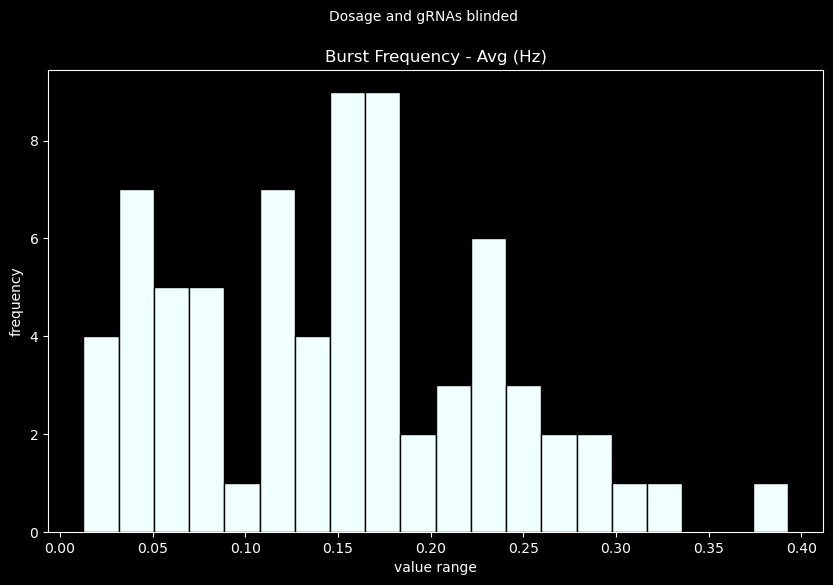

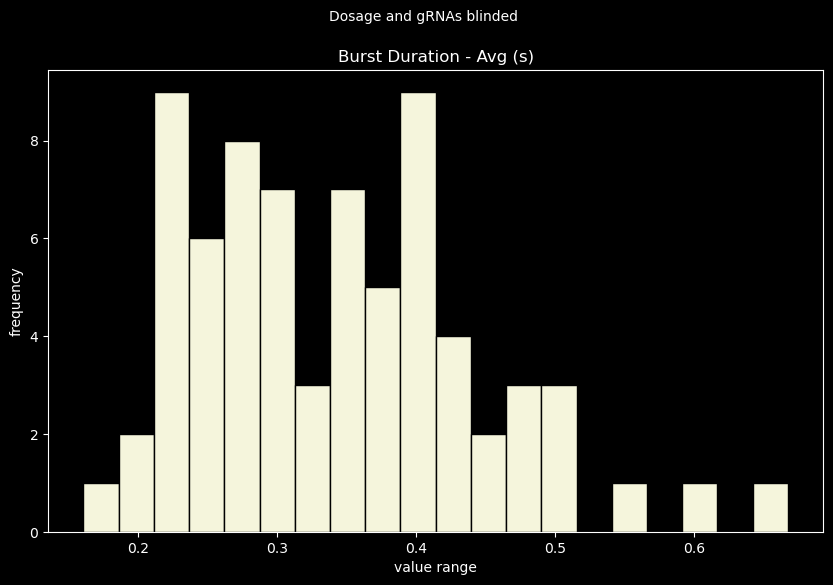

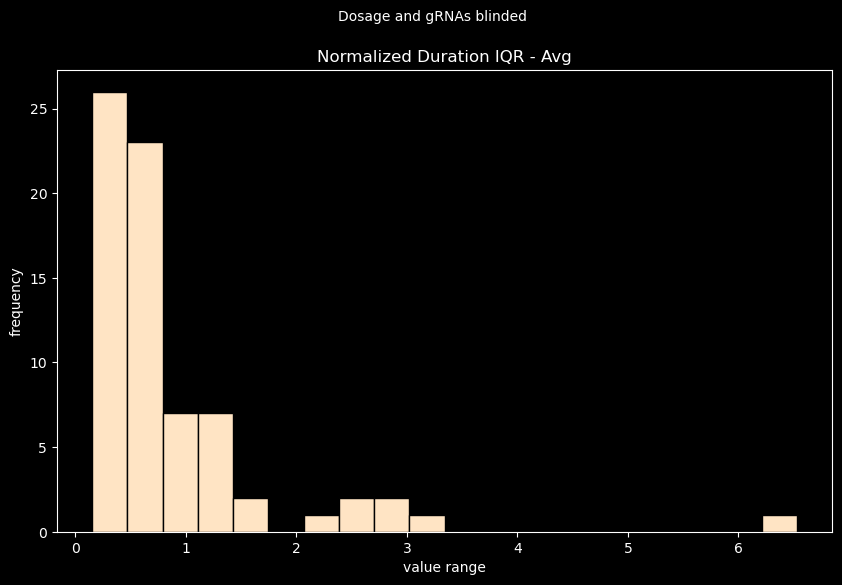

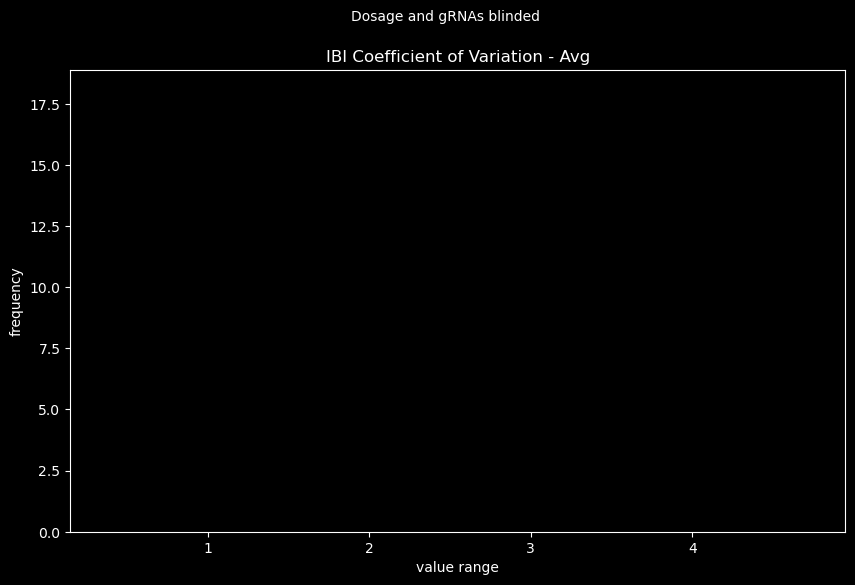

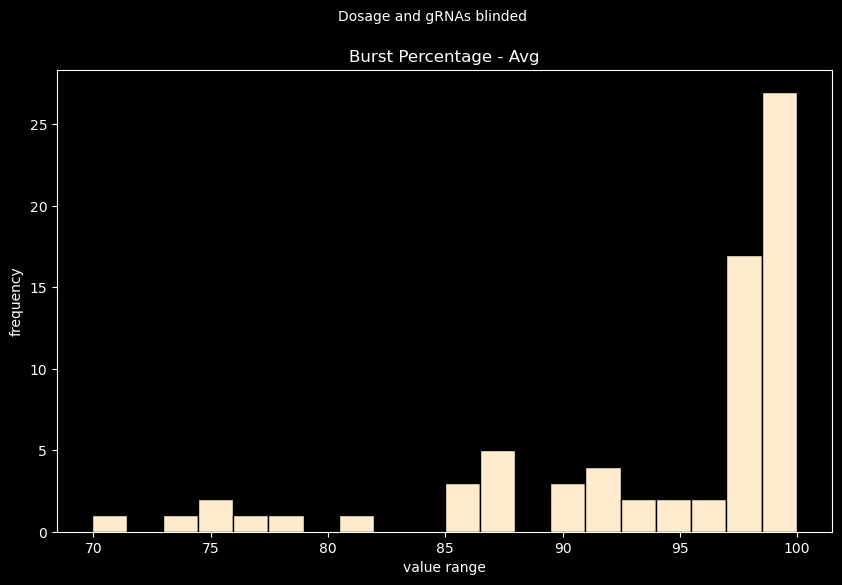

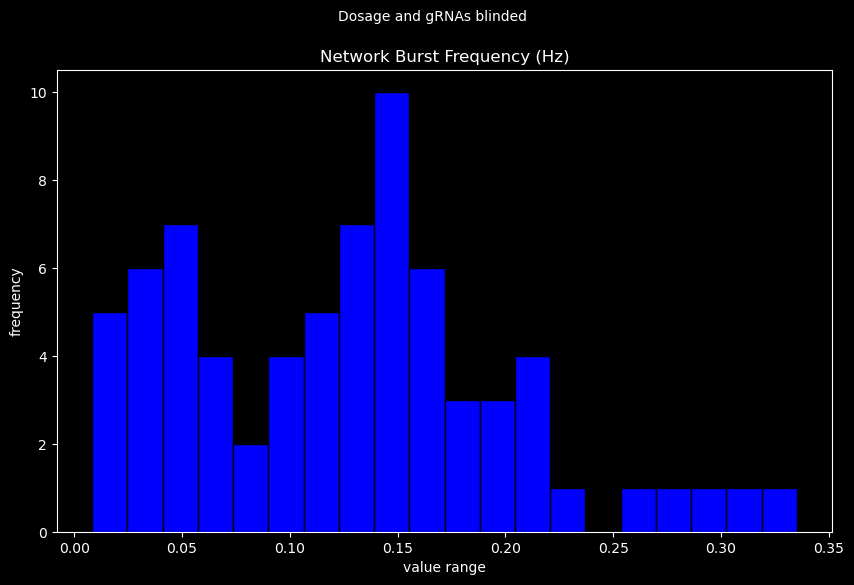

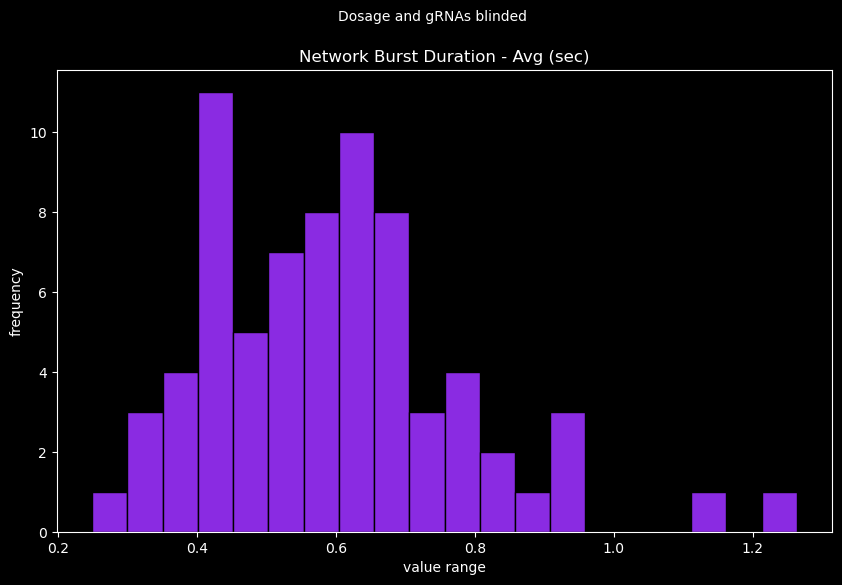

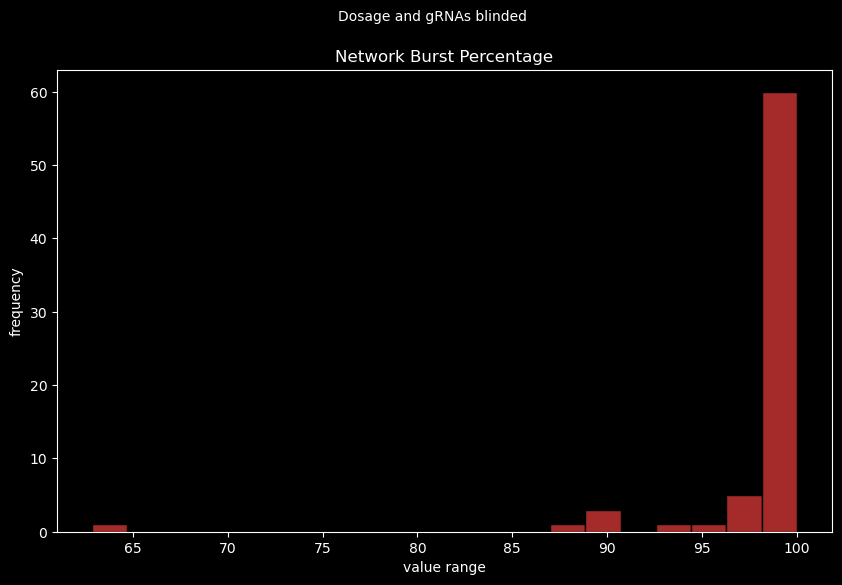

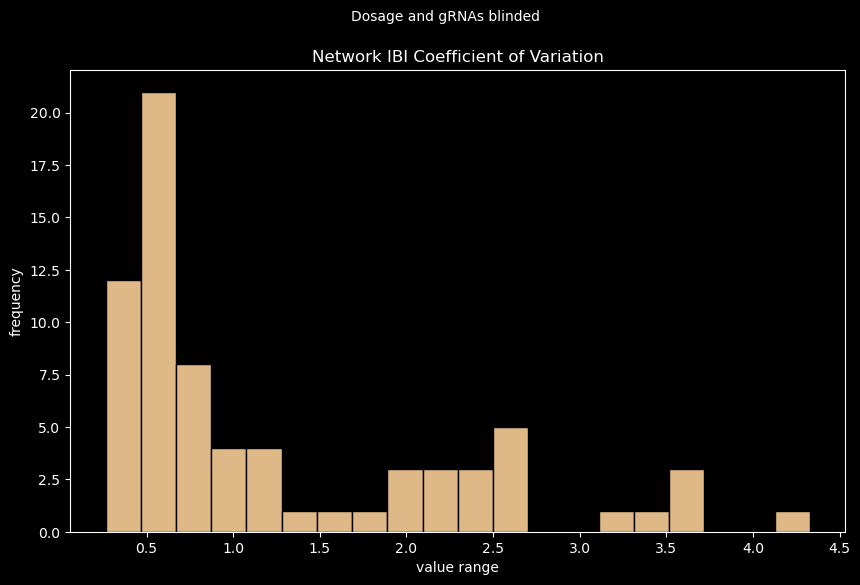

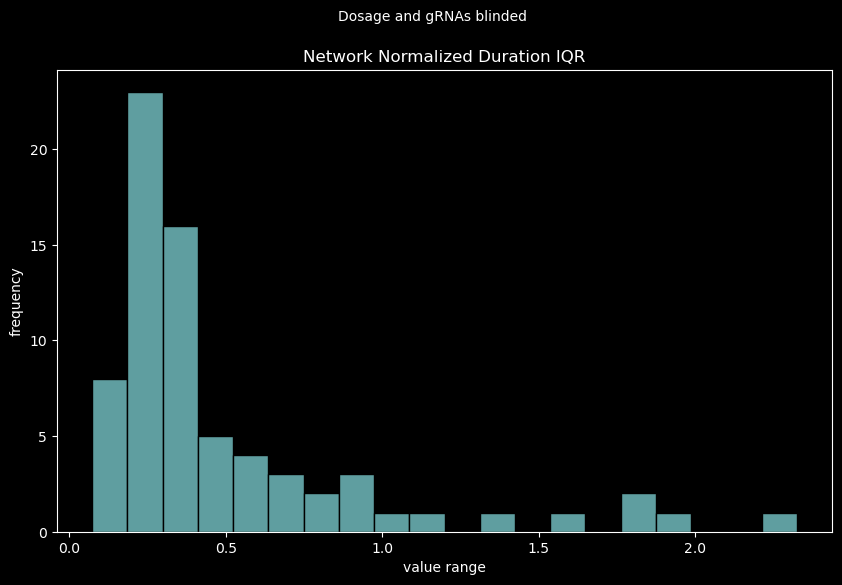

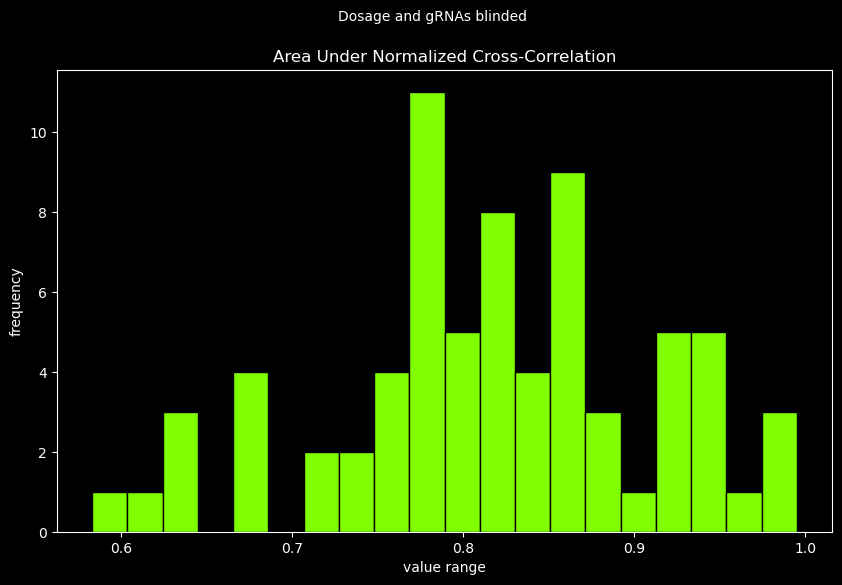

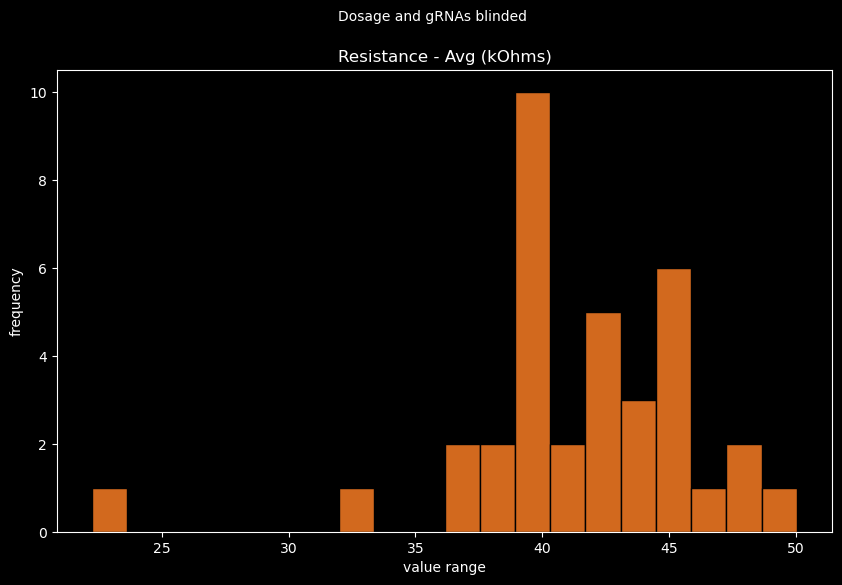

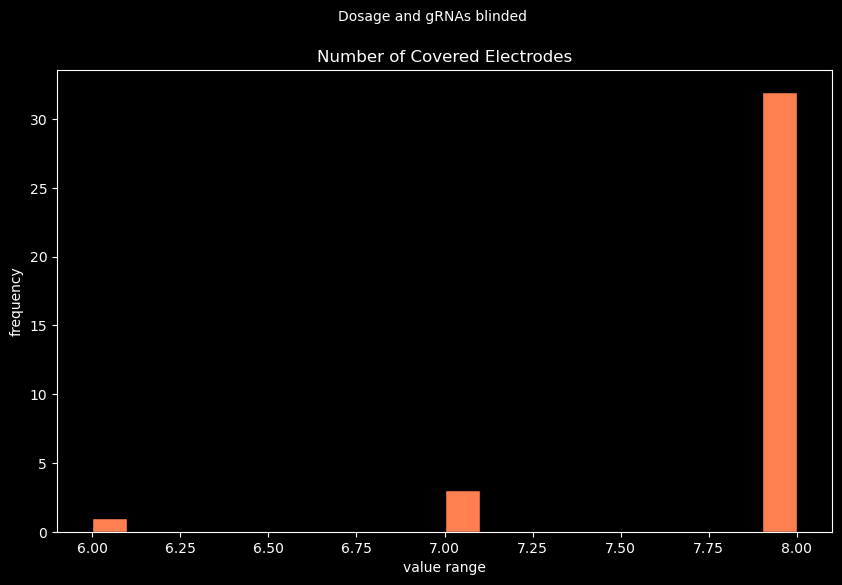

In [60]:
## lets do a quick histogram of all concentration and genes combined. each test
for i, test in enumerate(unt2_tests):
        # if i == 0:
                plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
                hdata = unt2_tests[test].drop(columns=['Chemical_Type'])
                hdata = hdata.to_numpy().flatten()
                plt.hist(hdata, bins=20, color=f'{colors[i]}', edgecolor='black')
                plt.suptitle(f'Dosage and gRNAs blinded', fontsize=10)
                plt.title(f'{test}')
                SAVE_FILE = f'../plots/histograms/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                        f'fullblind/{test}.png'
                ensure_dirs_exists(SAVE_FILE)
                plt.xlabel('value range')
                plt.ylabel('frequency')
                plt.savefig(SAVE_FILE)
                plt.show()

In [61]:
testsI_mapped['Number of Spikes']

,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,1.827421,3.278172,5.325334,3.735184,0.840568,3.100167,3.665484,2.135017,Div19_basal
Replicate2,0.901503,6.809265,0.281511,1.074499,4.000626,3.151920,3.726210,1.878548,Div19_basal
Replicate3,7.349958,2.711603,1.391903,2.271077,2.575334,2.032137,7.272120,2.567195,Div19_basal
Replicate4,1.503130,2.224958,1.152129,4.904215,0.460559,1.641068,5.093907,7.638564,Div19_basal
Replicate5,2.211811,3.282137,1.718907,4.165275,3.251043,0.664441,4.756469,1.001461,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate32,8.397249,10.686953,7.135265,13.484994,8.372447,10.636515,8.474990,7.671530,Div19_26uMbicucilin
Replicate33,7.917466,6.036265,8.013339,10.772614,8.221342,10.941017,10.209879,7.600459,Div19_26uMbicucilin
Replicate34,7.472489,3.577741,13.422468,15.018966,7.689037,6.824093,8.485202,9.812839,Div19_26uMbicucilin
Replicate35,9.322009,9.860358,13.581701,12.977699,14.904960,8.911630,11.590454,4.013339,Div19_26uMbicucilin


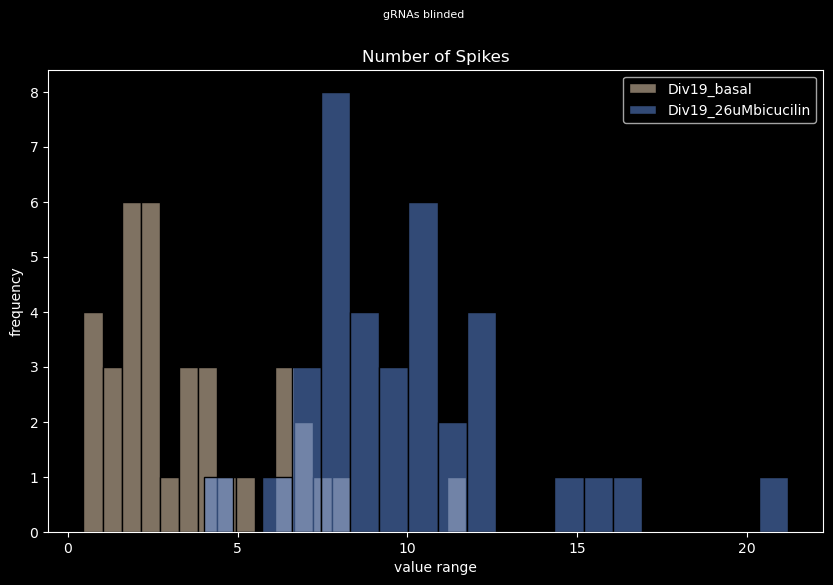

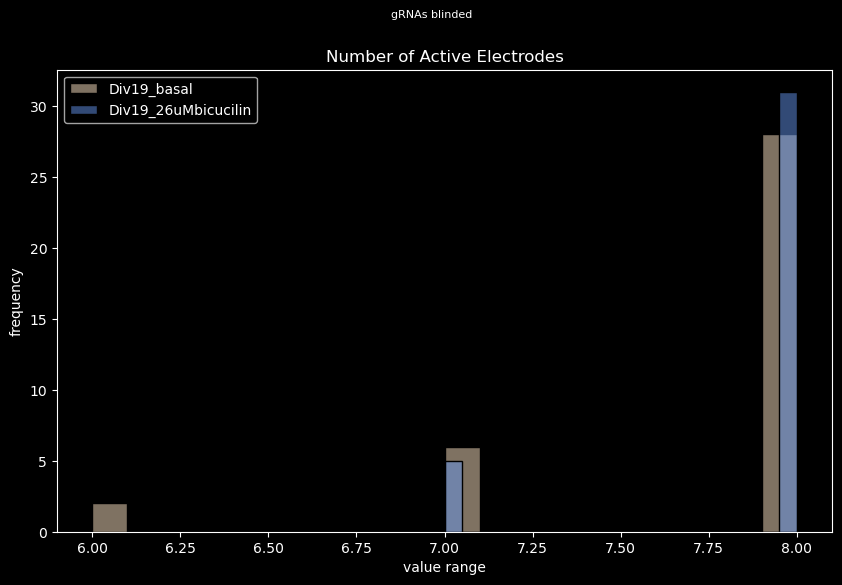

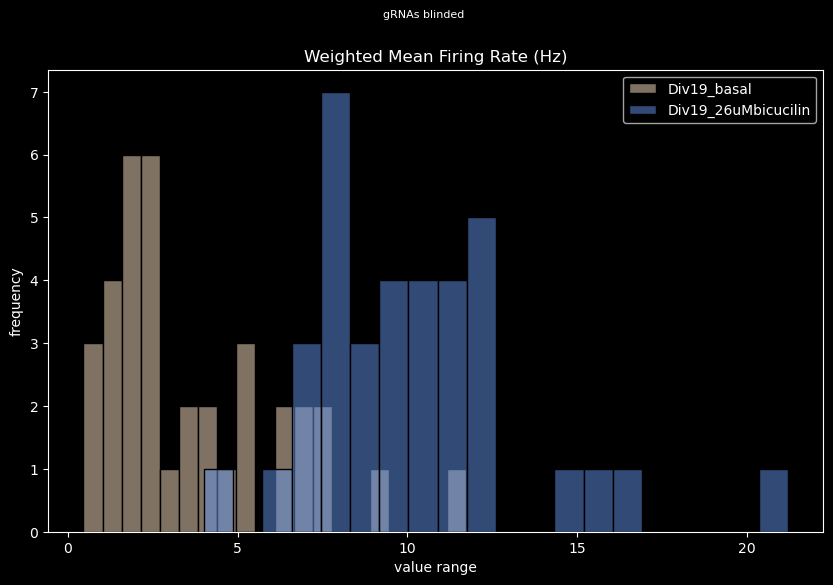

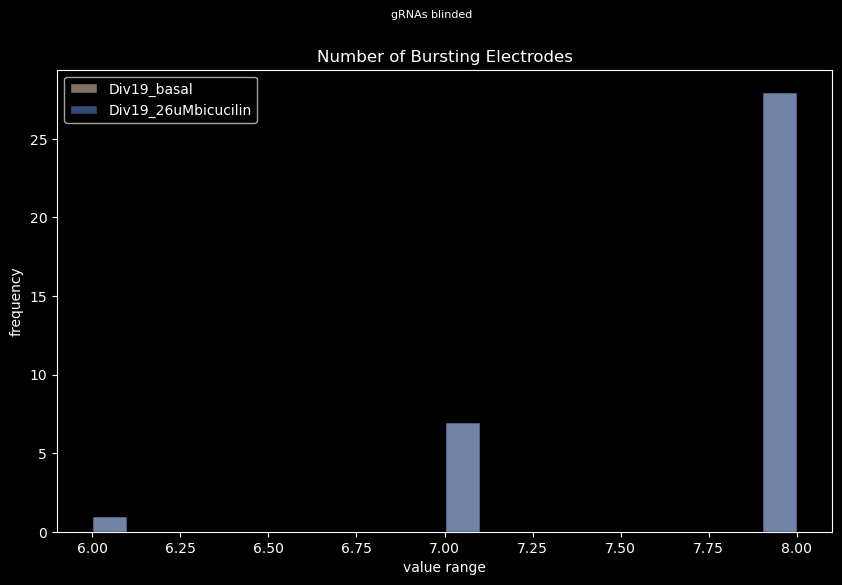

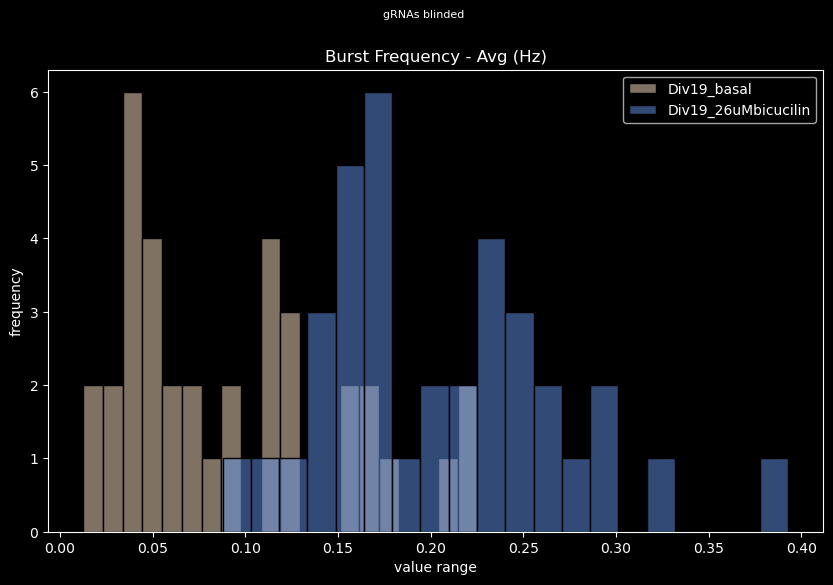

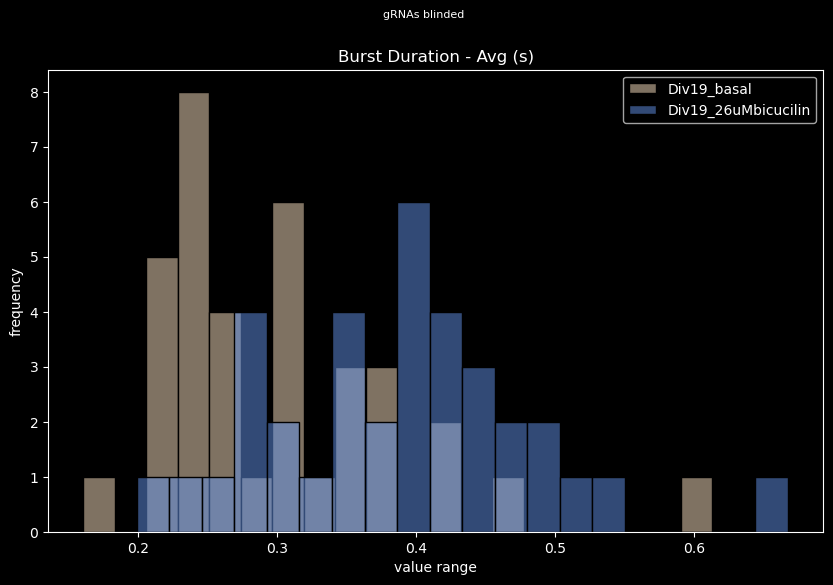

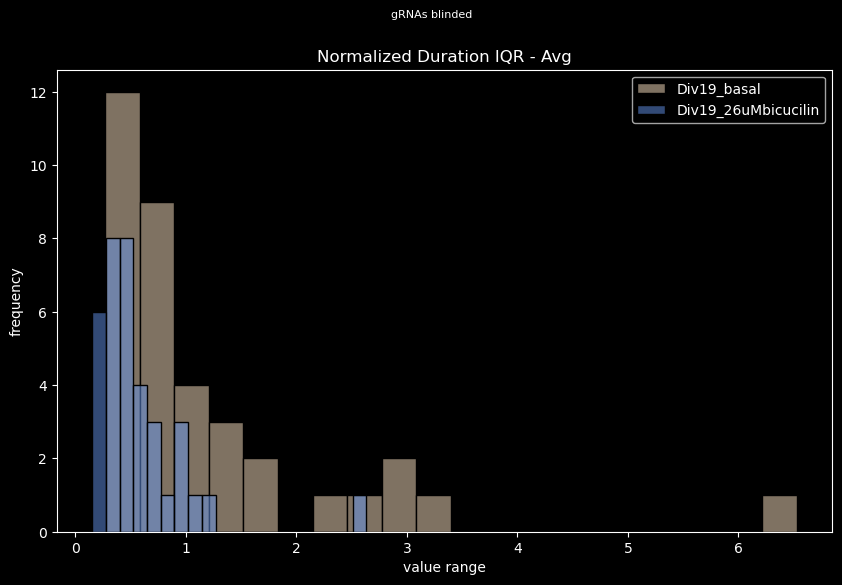

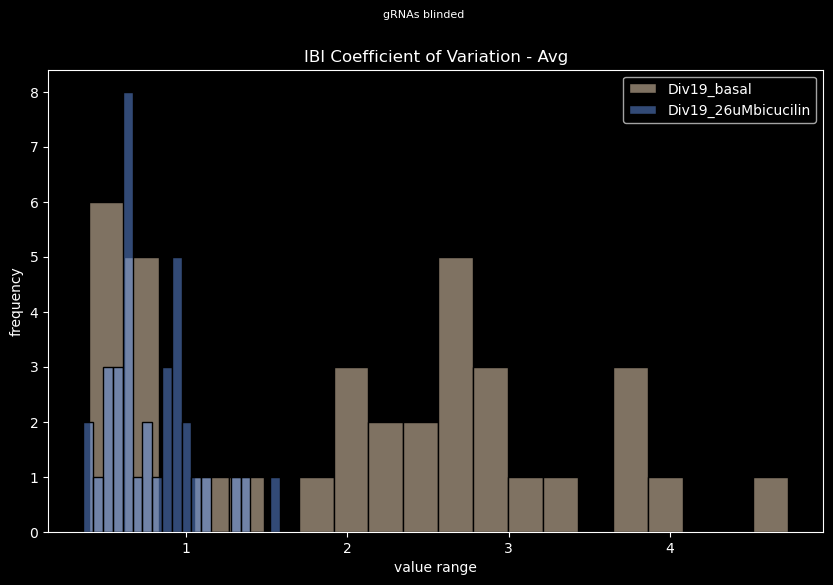

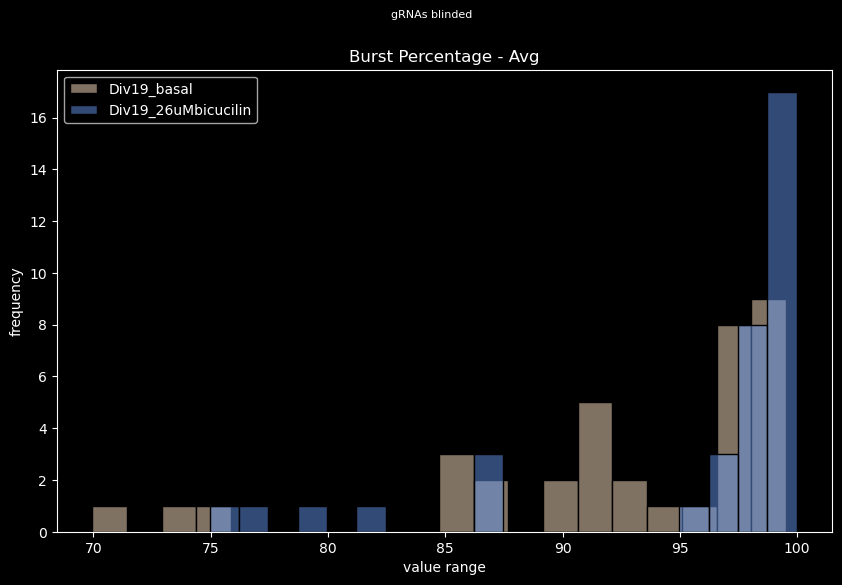

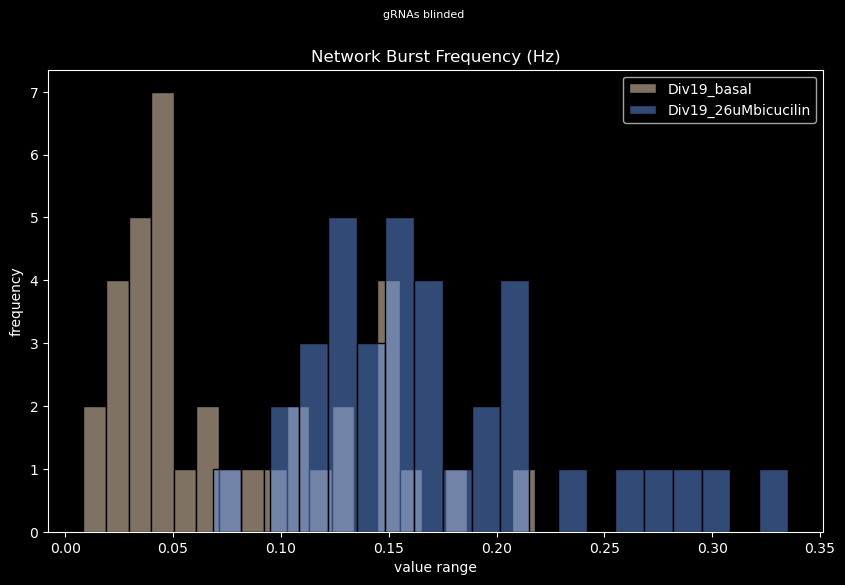

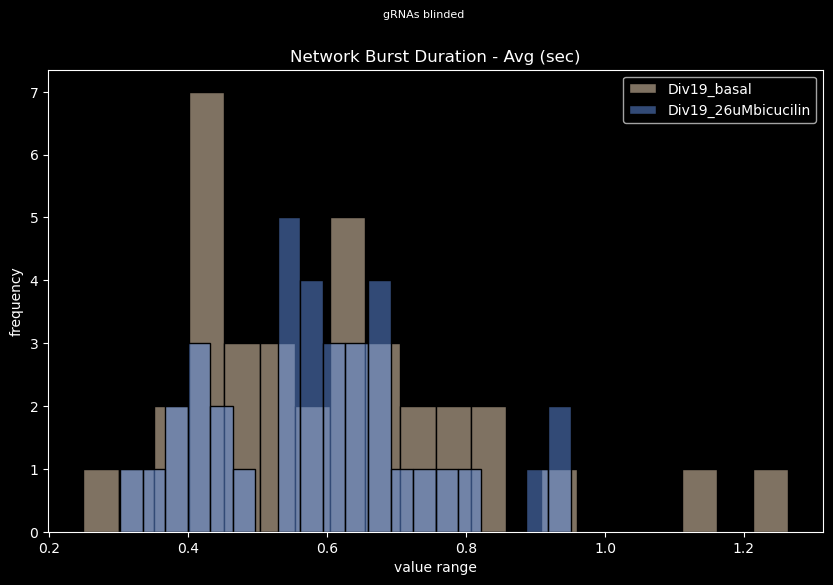

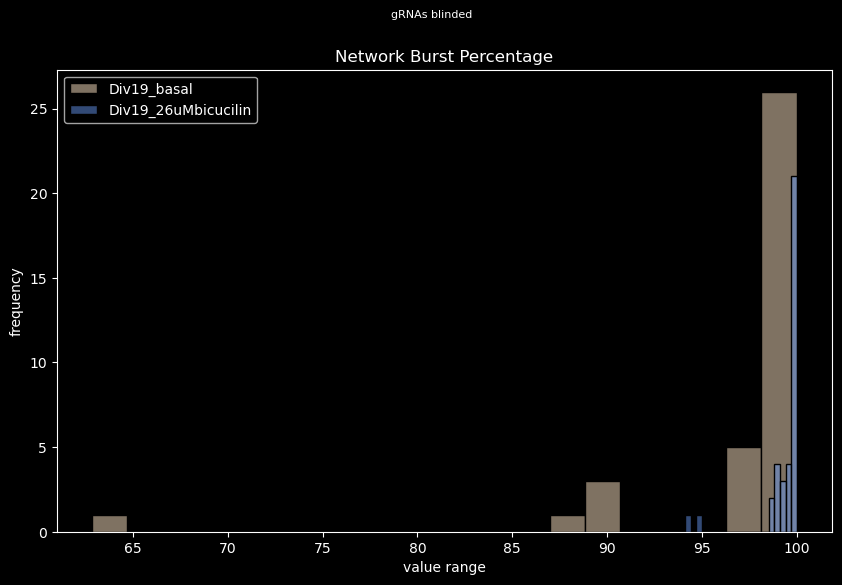

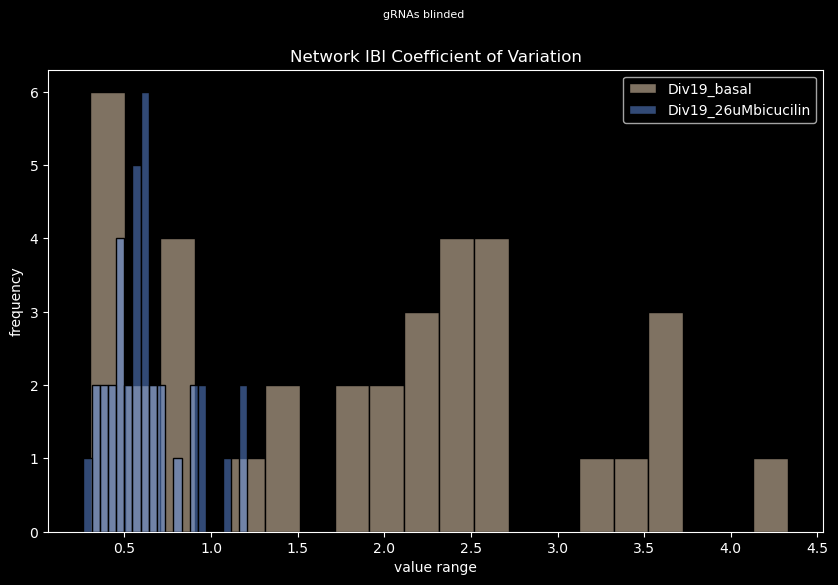

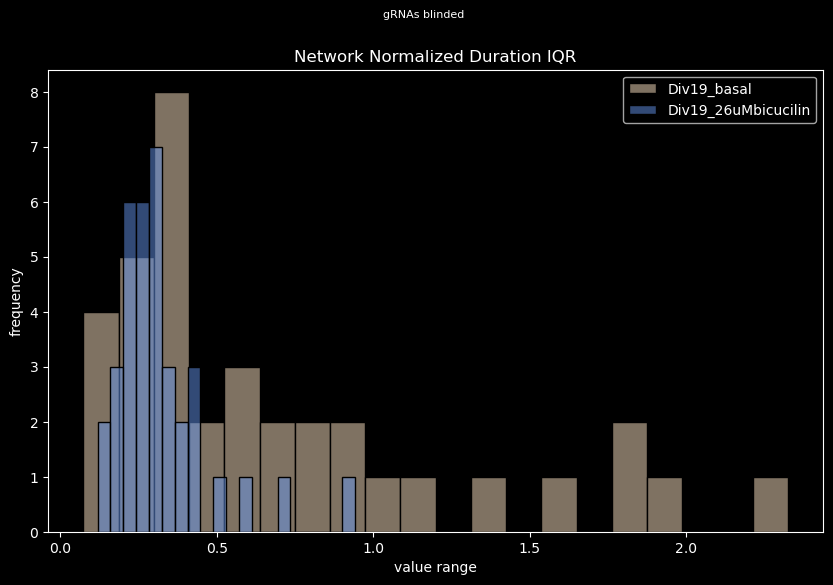

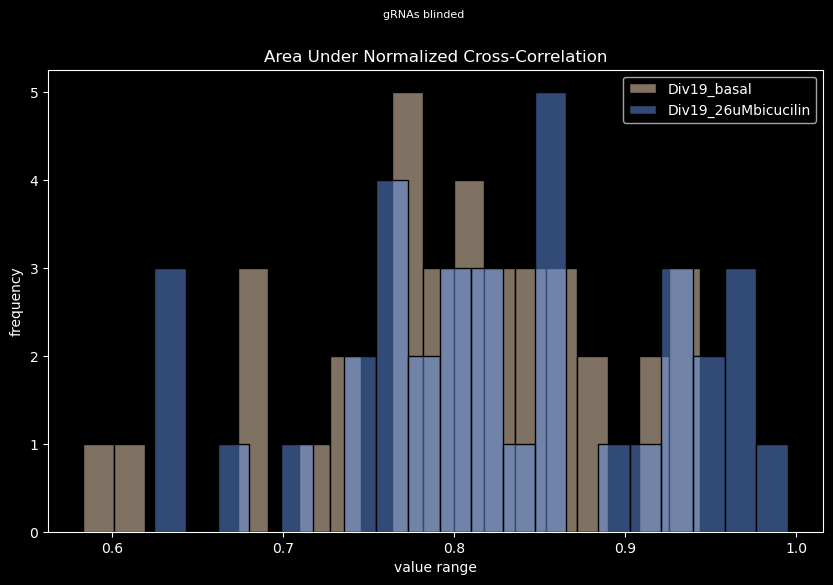

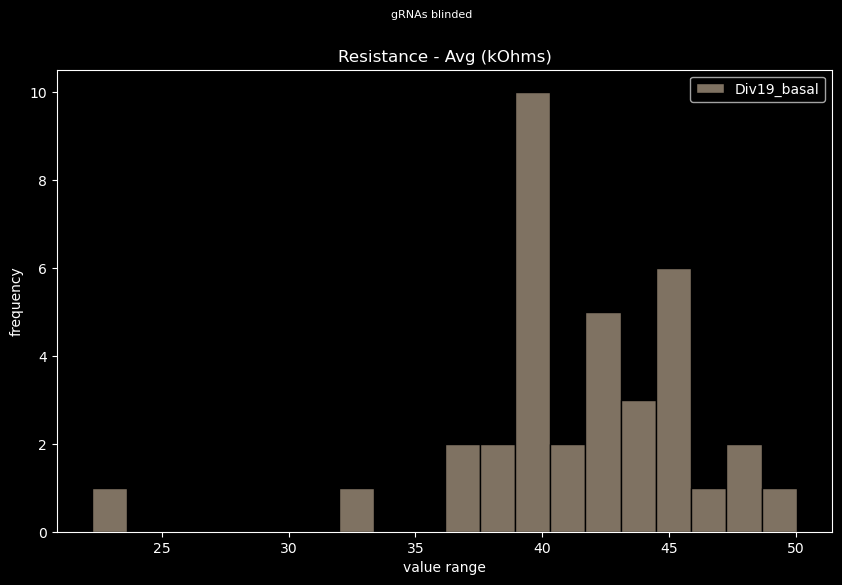

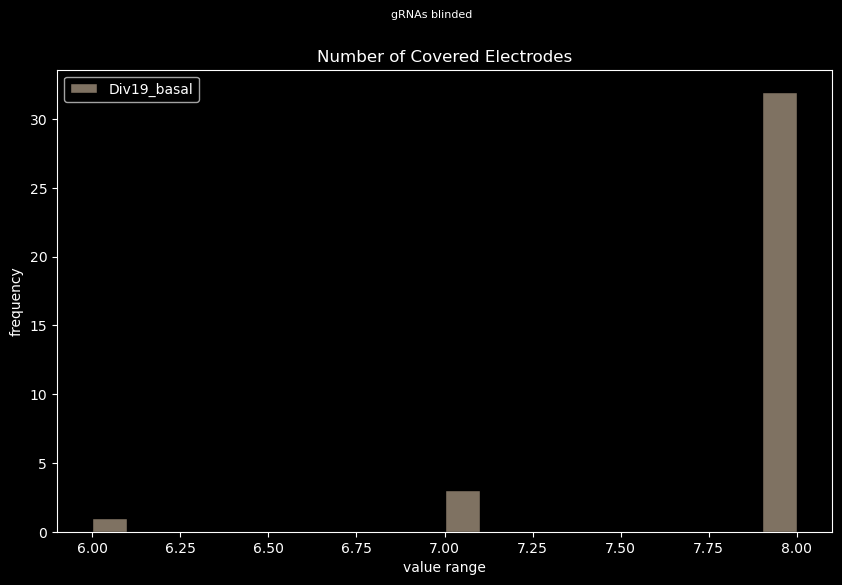

In [62]:
from matplotlib.colors import to_rgba
ncolors= list([colors[6], colors[17]])
## histogram w genes blinded.
for i, test in enumerate(unt2_tests):
    # if i == 0:
        plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
        for j, chem in enumerate(unt2_tests[test]['Chemical_Type'].unique()):
            hdata = unt2_tests[test][unt2_tests[test]['Chemical_Type'] == chem]
            hdata = hdata.drop('Chemical_Type', axis=1)
            hdata = hdata.to_numpy().flatten()
            color = to_rgba(ncolors[j % len(ncolors)], alpha=0.5)
            
            # Plot histogram with label
            plt.hist(hdata, bins=20, color=color, edgecolor='black', label=chem)
        plt.suptitle(f'gRNAs blinded', fontsize=8)
        plt.title(f'{test}')
        plt.xlabel('value range')
        plt.ylabel('frequency')
        SAVE_FILE = f'../plots/histograms/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                    f'geneblind/{test}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.legend()
        plt.savefig(SAVE_FILE)
        plt.show()
    

<Figure size 1000x600 with 0 Axes>

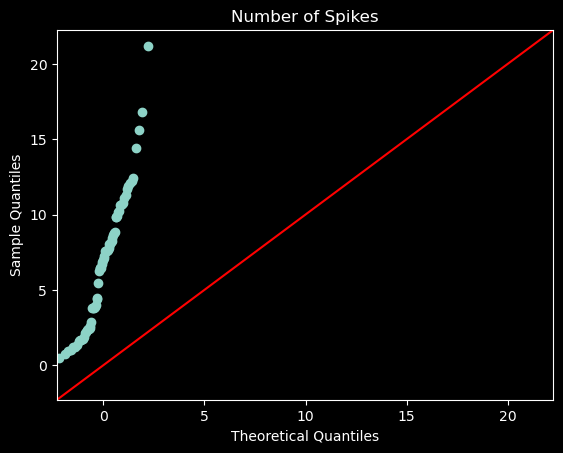

<Figure size 1000x600 with 0 Axes>

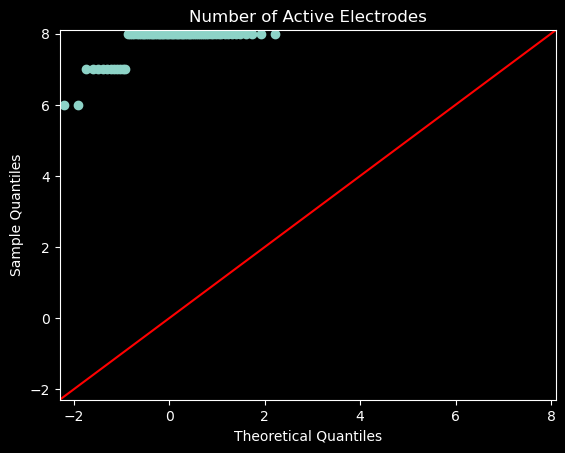

<Figure size 1000x600 with 0 Axes>

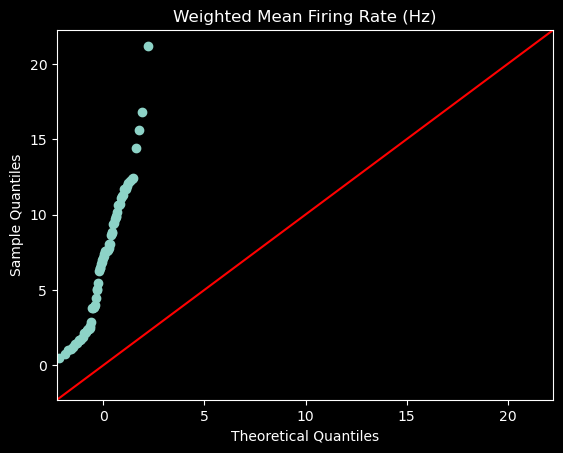

<Figure size 1000x600 with 0 Axes>

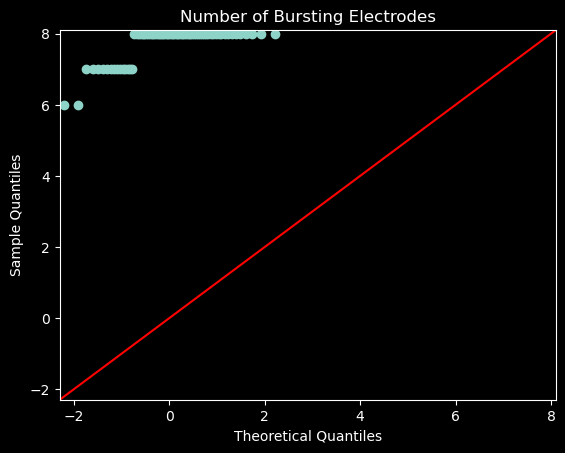

<Figure size 1000x600 with 0 Axes>

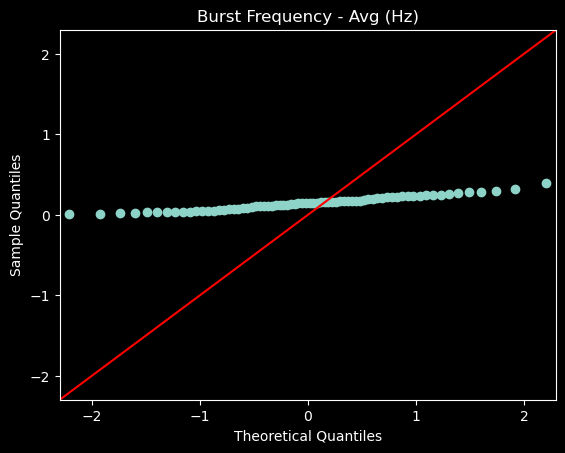

<Figure size 1000x600 with 0 Axes>

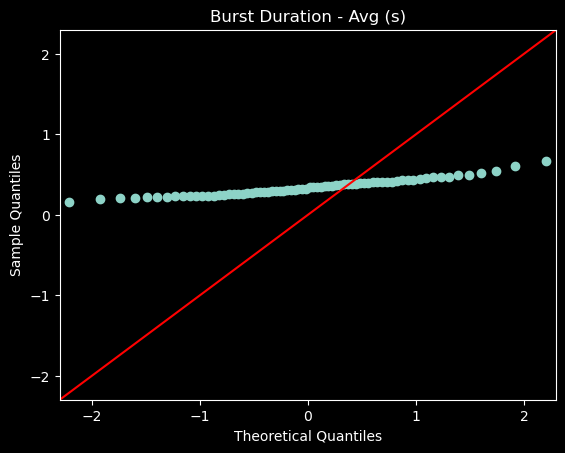

<Figure size 1000x600 with 0 Axes>

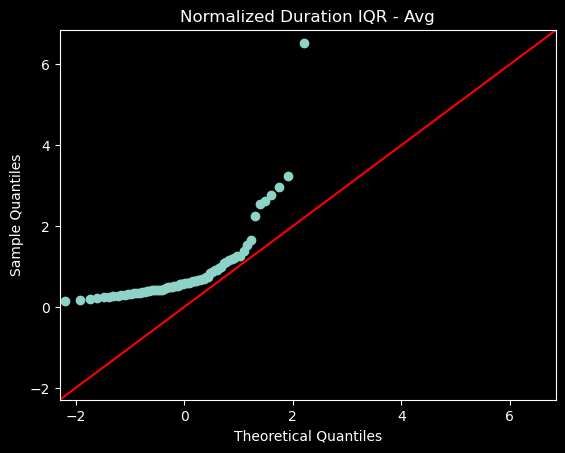

<Figure size 1000x600 with 0 Axes>

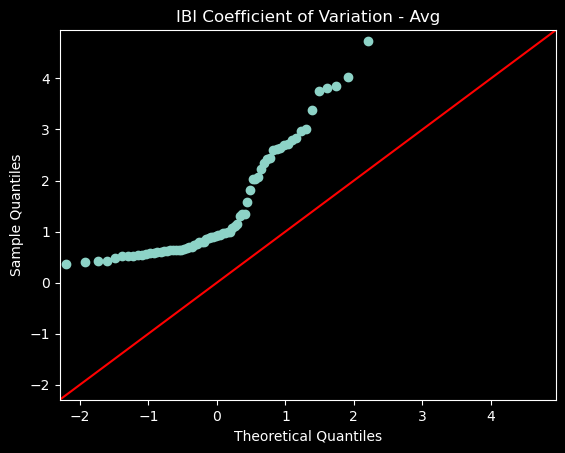

<Figure size 1000x600 with 0 Axes>

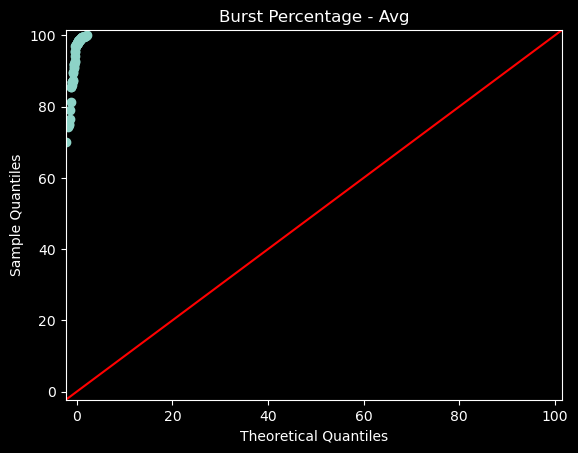

<Figure size 1000x600 with 0 Axes>

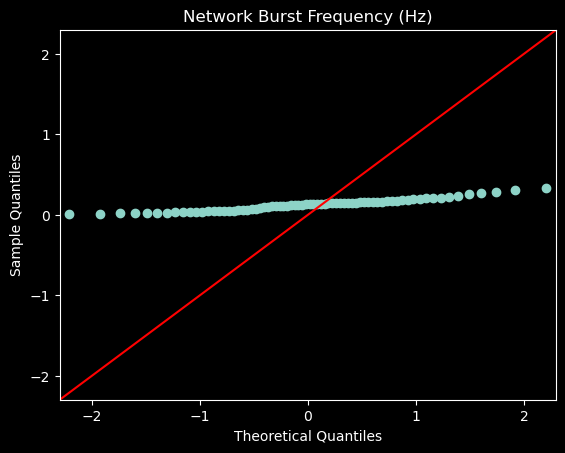

<Figure size 1000x600 with 0 Axes>

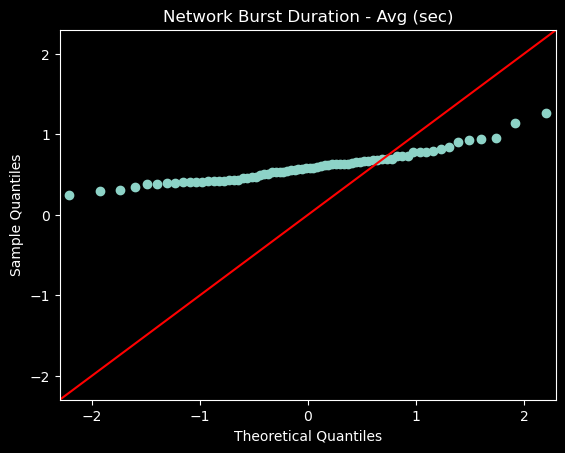

<Figure size 1000x600 with 0 Axes>

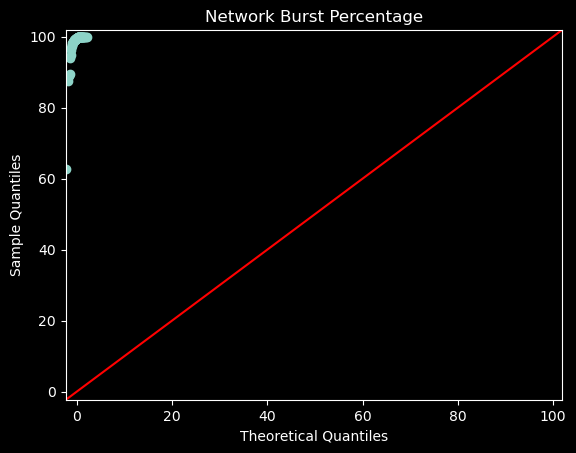

<Figure size 1000x600 with 0 Axes>

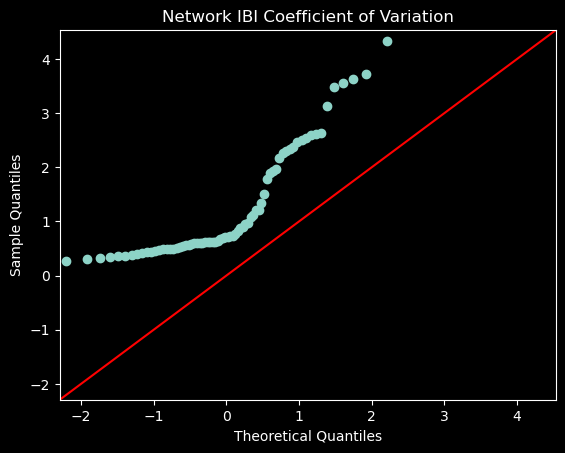

<Figure size 1000x600 with 0 Axes>

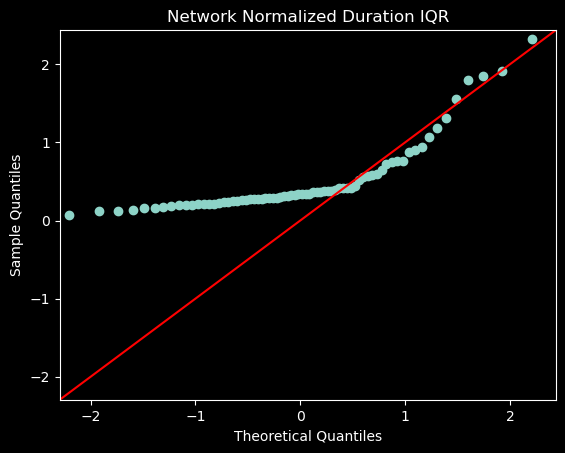

<Figure size 1000x600 with 0 Axes>

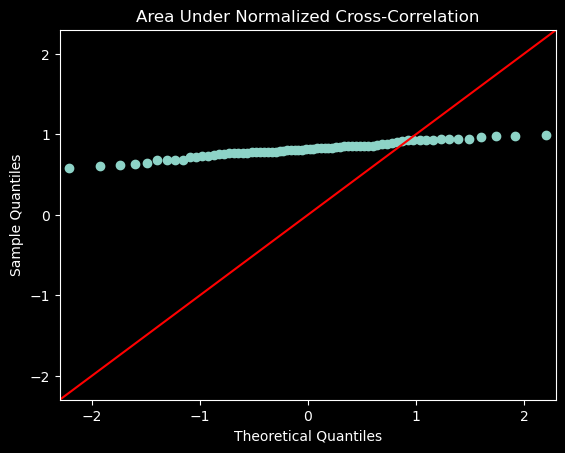

<Figure size 1000x600 with 0 Axes>

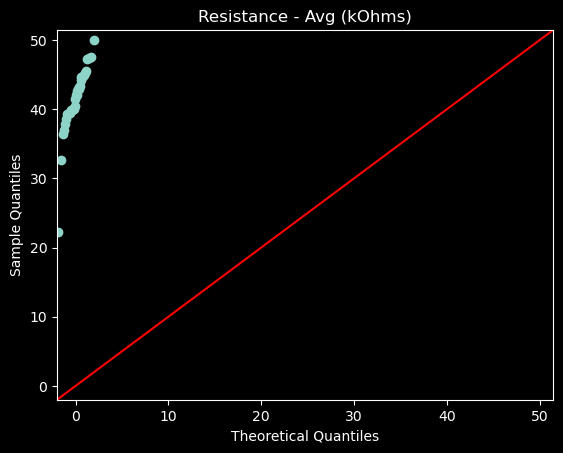

<Figure size 1000x600 with 0 Axes>

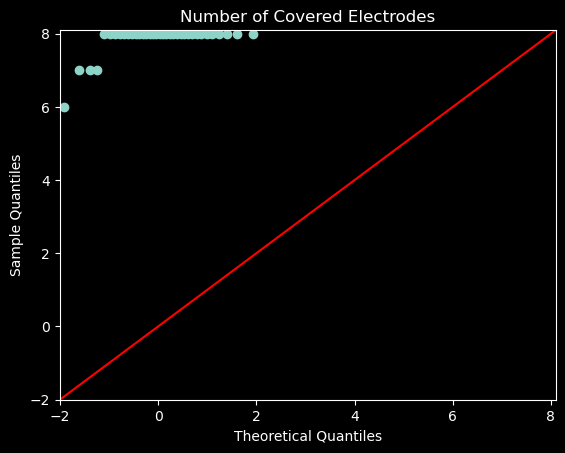

In [63]:
## lets do a quick histogram of all concentration and genes combined. each test
for i, test in enumerate(unt2_tests):
        plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
        hdata = unt2_tests[test].drop('Chemical_Type', axis=1)
        hdata = hdata.to_numpy().flatten()
        fig = sm.qqplot(hdata, line='45')  # '45' adds a 45-degree reference line
        plt.title(f'{test}')
        SAVE_FILE = f'../plots/qqplots/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'fullblind/{test}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.savefig(SAVE_FILE)
        plt.show()

Lucio mentioned looking at controls only first will be helpful. Therefore the first three types of plots are comparing two different controls with varying concentration dosages for a singular test. 

Plot types 4-6 contain all genes between concentrations 
